In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as T

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [4]:
transform = T.Compose([
    T.ToTensor(),
    T.Resize((32,32)),
    T.Normalize((0.1037,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST("MNIST", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("MNIST", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=4 )

100%|██████████| 9.91M/9.91M [00:10<00:00, 927kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 224kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 742kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.20MB/s]


In [9]:
images, labels = next(iter(train_loader))
images.shape

torch.Size([32, 1, 32, 32])

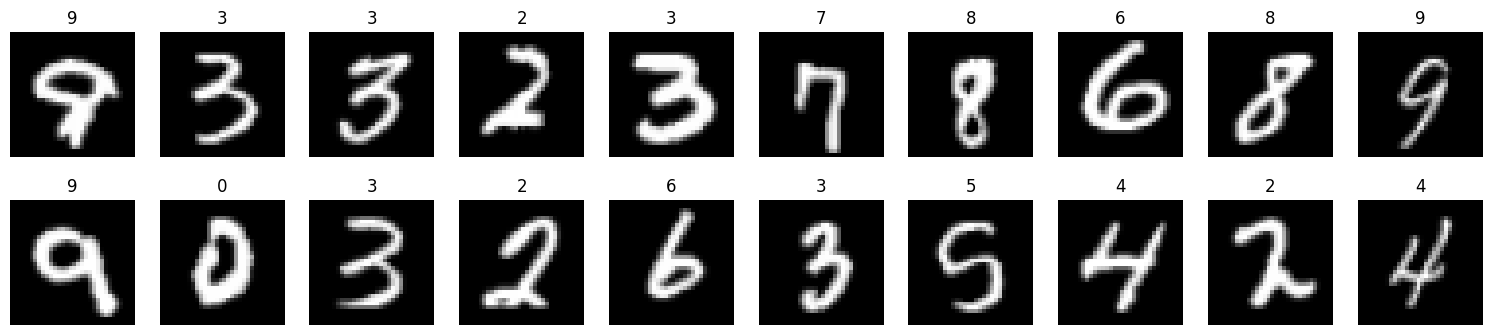

In [16]:
cols = 10
rows = 2
fig = plt.figure(figsize=(2*cols - 1, 2*rows))
k = 0
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i*rows + j + 1)
        ax.imshow(np.transpose(images[k], (1,2,0)), cmap='gray')
        ax.axis('off')
        ax.grid("off")
        ax.set_title(labels[k].item())
        k+=1
plt.show()

Напишем функцию для обучения в эпохе

In [25]:
def train_epoch(model, optimizer, criterion):
    loss_log, acc_log = [], []
    model.train()
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch.to(device)
        y_batch.to(device)
        
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        pred = torch.max(logits, dim=1)[1].numpy()
        acc = np.mean(pred == y_batch.numpy())
        acc_log.append(acc)
    return loss_log, acc_log

Теперь напишем для теста

In [26]:
def test(model, criterion):
    acc_log, loss_log = [], []
    model.eval()
    for batch_idx, (x_batch, y_batch) in enumerate(val_loader):
        x_batch.to(device)
        y_batch.to(device)
        
        with torch.no_grad():
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
        
        loss_log.append(loss.item())
        pred = torch.max(logits, 1)[1].numpy()
        acc = np.mean(pred == y_batch.numpy())
        acc_log.append(acc)
    return loss_log, acc_log

Визуализация

In [27]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    
    axs[0].plot(train_losses, label='train')
    
    points = np.array(test_losses)
    axs[0].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(train_accuracies, label='train')
    points = np.array(test_accuracies)
    axs[1].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('step')
        ax.legend()

    plt.show()

Применим прошлые функции в следующей общей

In [28]:
def train(model, optimizer, criterion, batch_size, epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, optimizer, criterion)
        val_loss, val_acc = test(model, criterion)
        
        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        steps = train_dataset.train_labels.shape[0] / batch_size
        
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        
        plot_losses(train_log, val_log, train_acc_log, val_acc_log)  
        
    return {
        'train_logloss': np.mean(train_loss), 'train_accuracy': np.mean(train_acc),
        'val_logloss': val_log[-1], 'val_accuracy': val_acc_log[-1]
    }

In [29]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)
        )
        
        self.head = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Mish(),
            nn.Linear(in_features=84, out_features=10)
        )
    
    def forward(self, image):
        out = self.encoder(image)
        out = out.squeeze(-1).squeeze(-1)
        return self.head(out)
    
    def get_embedding(self, image):
        out = self.encoder(image)
        return out.squeeze(-1).squeeze(-1)

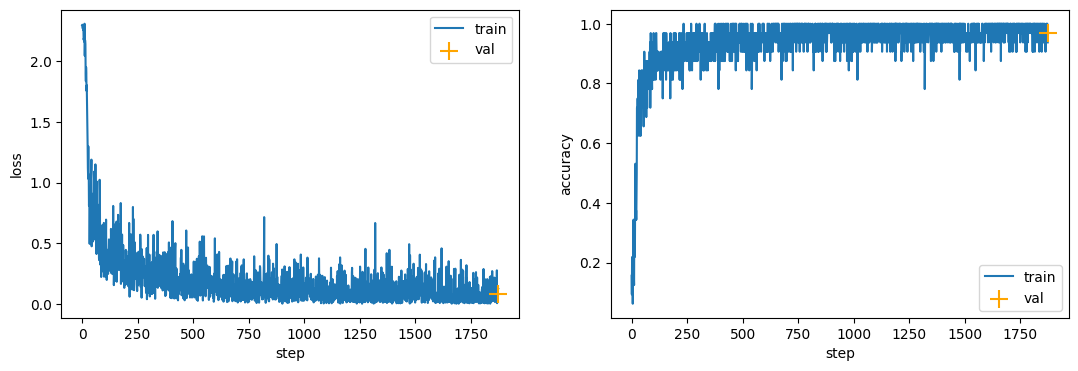

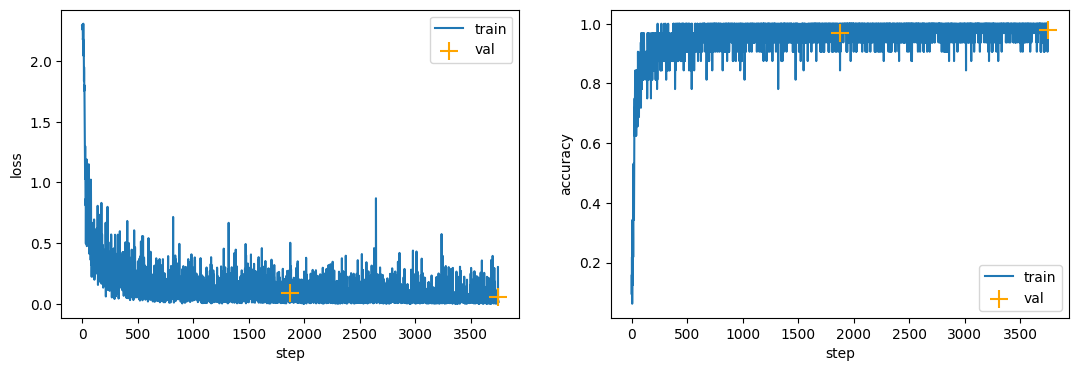

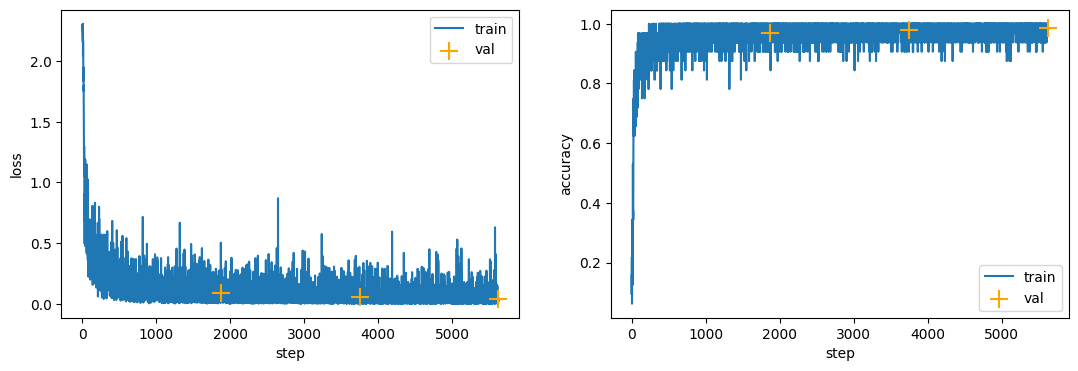

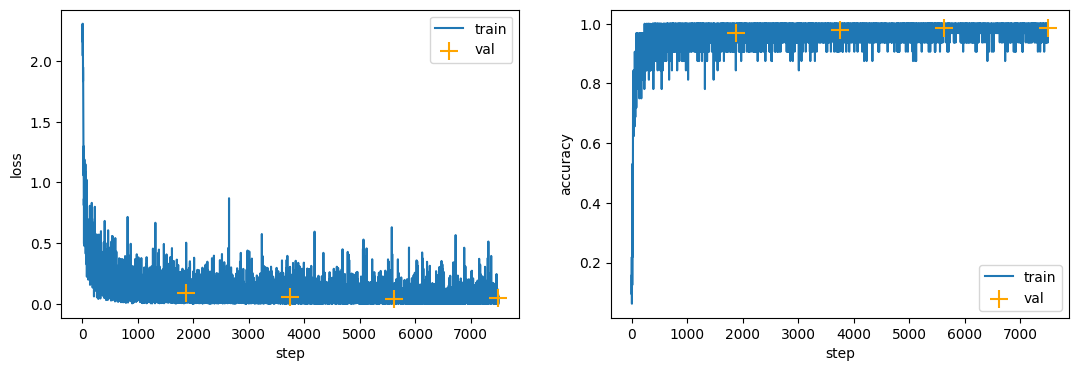

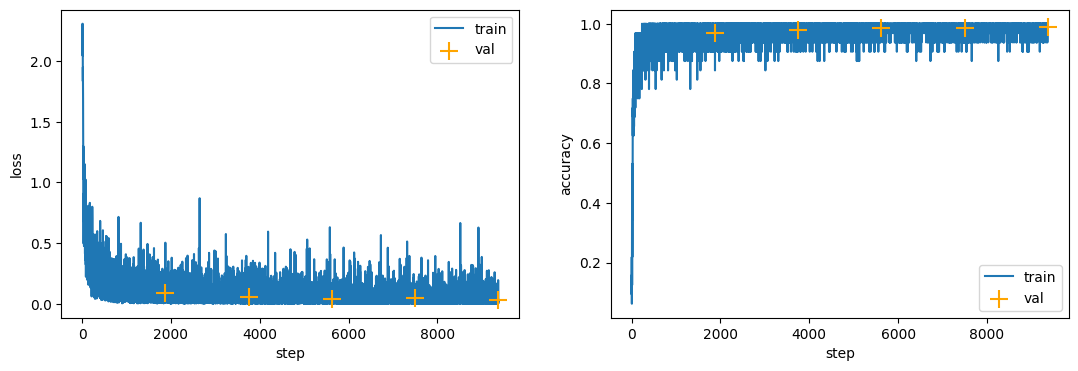

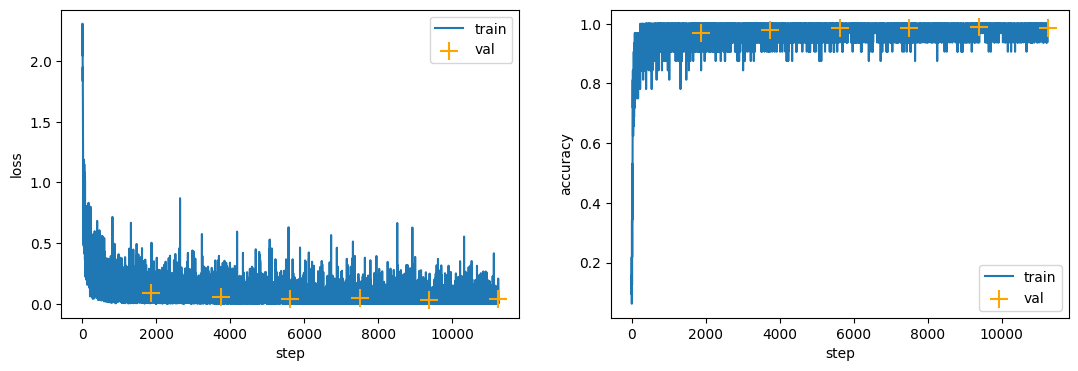

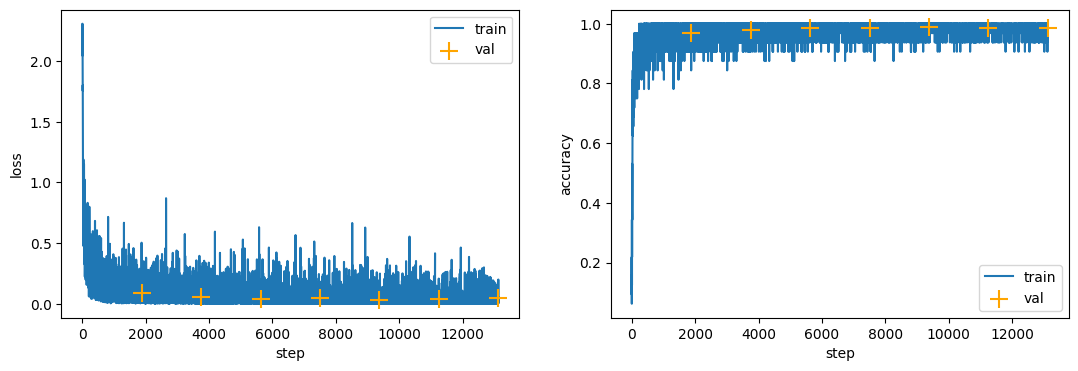

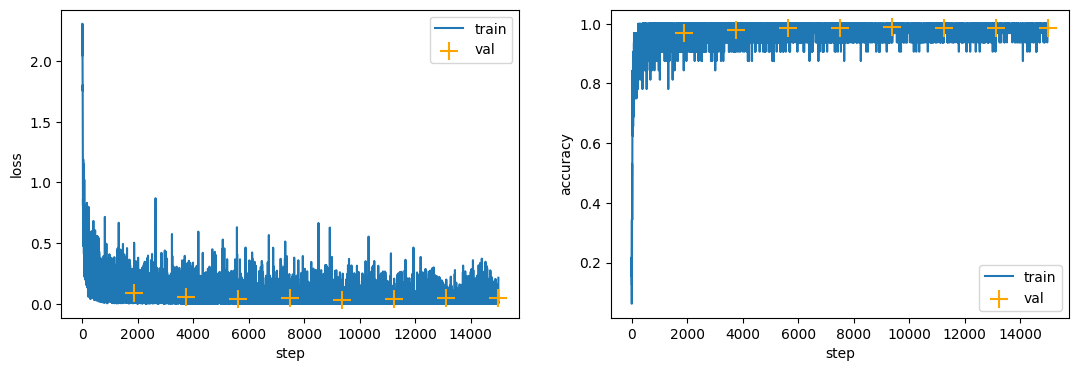

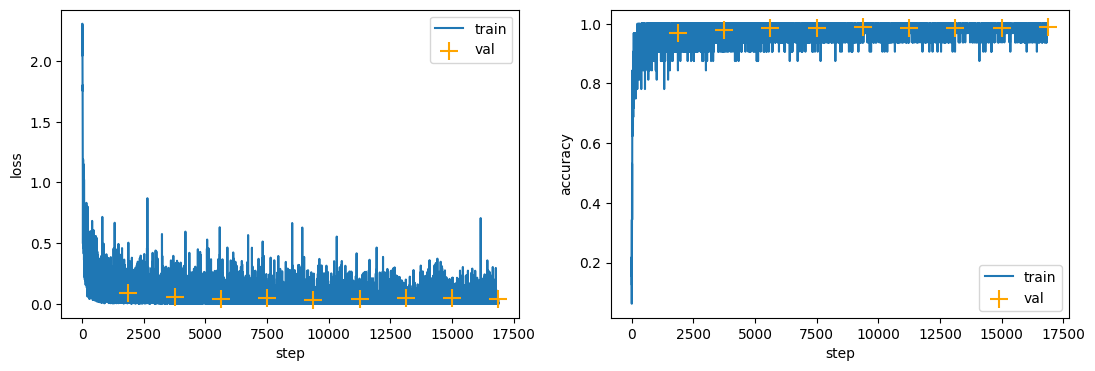

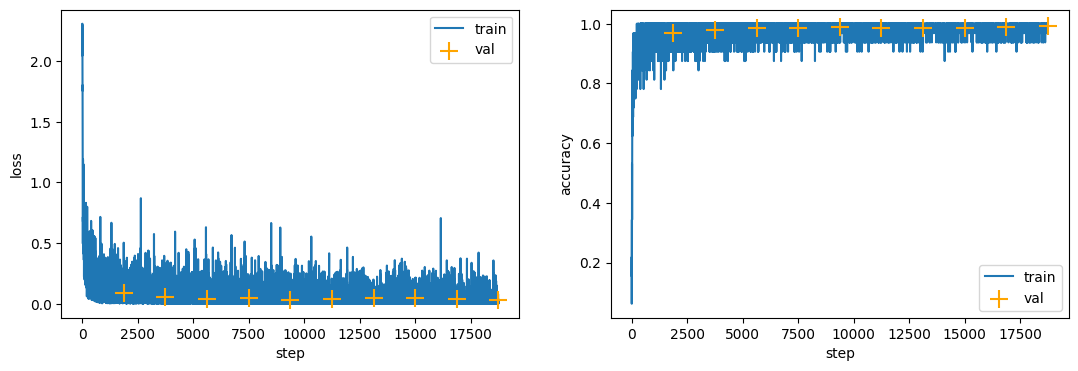

In [31]:
model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

final = train(model, optimizer, criterion, batch_size=32, epochs=10)

In [32]:
print('train_logloss', final['train_logloss'])
print('val_logloss', final['val_logloss'][-1])

print('train_accuracy', final['train_accuracy'])
print('val_accuracy', final['val_accuracy'][-1])

train_logloss 0.0212806704350193
val_logloss 0.03125611721452079
train_accuracy 0.9929
val_accuracy 0.9909145367412141
